In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from birdCLEFloaddata import load_audiofile,load_metadata,get_melspectrogram
from birdCLEFFunctions import Dynamic_CNN, Dynamic_CNN2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Resize
from torch.utils.data import DataLoader, TensorDataset
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import Grayscale, ToPILImage
import torchvision
import soundfile as sf
import random
import math

plt.rcParams['figure.dpi'] = 200


In [2]:
torch.cuda.is_available()

True

In [9]:
#load data
path = r"C:\Users\zhakk\Desktop\Uni\Kandidat\AML-BirdCLEFproject\data\birdCLEF2023"

meta_data = load_metadata(path,trim=True)


In [10]:
pd.set_option('display.max_rows', None)
print(meta_data['common_name'].value_counts())

Western Yellow Wagtail              50
Tropical Boubou                     50
Barn Swallow                        50
Singing Cisticola                   50
Spotted Morning-Thrush              50
Yellow-rumped Tinkerbird            50
Gray-headed Bushshrike              50
Black Cuckoo                        50
African Pied Wagtail                50
Egyptian Goose                      50
Cattle Egret                        50
Rattling Cisticola                  50
Fork-tailed Drongo                  50
Collared Sunbird                    50
Lawrence's Goldfinch                50
Thrush Nightingale                  50
Gray-capped Warbler                 50
Village Weaver                      50
Laughing Dove                       50
Dideric Cuckoo                      50
Ring-necked Dove                    50
Black-backed Puffback               50
African Paradise-Flycatcher         50
Sombre Greenbul                     50
White-browed Robin-Chat             50
African Emerald Cuckoo   

In [6]:
def load_audiofile2(filepath, cutoff_time):
    #Function that takes a file and cutoff time to create training and validation sets for training
    #If the audioclip is lower than the cutoff_time then the clip is looped untill desired duration reached
    audio, sr = sf.read(filepath)
    duration = len(audio) / sr


    if duration >= cutoff_time:
        training_audio = audio[:int(sr * 15)]
        validation_audio = audio[int(sr * 15):int(sr * 30)]
    else:
        
        loop_count = int(np.ceil(cutoff_time / duration))
        audio = np.tile(audio, loop_count)

        training_audio = audio[:int(sr * 15)]
        validation_audio = audio[int(sr * 15):int(sr * 30)]

    return training_audio.astype(np.float32), validation_audio.astype(np.float32), sr

## First/simple data extraction methods

### Audio data

In [ ]:
#Generate audio data
training_data = []
validation_data = []
for i in range(50):
    train_audio,validation_audio, sr = load_audiofile2(meta_data['filename'][i],30)
    training_data.append([get_melspectrogram(train_audio),meta_data['common_name'][i]])
    validation_data.append([get_melspectrogram(validation_audio),meta_data['common_name'][i]])


training_data = np.asarray(training_data)
validation_data = np.asarray(validation_data)
label_mapping = {label: index for index, label in enumerate(set(meta_data['common_name'].unique()))}
training_data[:,1] = [label_mapping.get(label, -1)+1 for label in training_data[:,1]]
validation_data[:,1] = [label_mapping.get(label, -1)+1 for label in validation_data[:,1]]


In [ ]:
import random

# Generate audio data
training_data = []
validation_data = []
birds_with_single_clip = []

# Iterate through each unique bird
for bird in meta_data['common_name'].unique():
    print(bird)
    # Get all audio clips for the bird
    bird_clips = meta_data[meta_data['common_name'] == bird]['filename'].tolist()
    # If the bird has only one clip, split it into two halves
    if len(bird_clips) == 1:
        birds_with_single_clip.append(bird)
    else:
        # Randomly select one clip for validation and the rest for training
        random.shuffle(bird_clips)
        training_clip = bird_clips[1:]
        validation_clip = bird_clips[0]
    
    # Load and process the training clip
    for clip in training_clip:
        train_audio, sr = load_audiofile(clip)
        training_data.append([get_melspectrogram(train_audio), bird])
    
    # Load and process the validation clip
    validation_audio, sr = load_audiofile(validation_clip)
    validation_data.append([get_melspectrogram(validation_audio), bird])

# Split the single clips into training and validation
random.shuffle(birds_with_single_clip)
split_index = len(birds_with_single_clip) // 2
training_single_clips = birds_with_single_clip[split_index:]
validation_single_clips = birds_with_single_clip[:split_index]

# Append the single clips to the training and validation data
for bird in birds_with_single_clip:
    clip = meta_data[meta_data['common_name'] == bird]['filename'].tolist()[0]
    audio, sr = load_audiofile(clip)
    split_index = len(audio) // 2
    val_audio = audio[:split_index]
    train_audio = audio[split_index:]
    validation_data.append([get_melspectrogram(val_audio), bird])
    training_data.append([get_melspectrogram(train_audio), bird])


# Convert to numpy arrays
training_data = np.asarray(training_data)
validation_data = np.asarray(validation_data)

# Map labels to indices
label_mapping = {label: index for index, label in enumerate(set(meta_data['common_name'].unique()))}
training_data[:, 1] = [label_mapping.get(label, -1) + 1 for label in training_data[:, 1]]
validation_data[:, 1] = [label_mapping.get(label, -1) + 1 for label in validation_data[:, 1]]


In [ ]:
validation_audio.ndim



In [ ]:
import random

#Generate audio data
training_data = []
validation_data = []
cutoff_time = 30

for common_name in meta_data['common_name'].unique():
    i = meta_data.loc[meta_data['common_name'] == common_name].index[0] 
    train_audio,validation_audio, sr = load_audiofile2(meta_data['filename'][i],cutoff_time)
    training_data.append([get_melspectrogram(train_audio,n_fft=2048,hop_length=512,n_mels=128,fmin=40,fmax=15000,power=2.0,top_db=100),meta_data['common_name'][i]])
    validation_data.append([get_melspectrogram(validation_audio,n_fft=2048,hop_length=512,n_mels=128,fmin=40,fmax=15000,power=2.0,top_db=100),meta_data['common_name'][i]])

#Random selection of 100 data points, each point is taken in groups of 5
selected_spots = random.sample(range(len(meta_data) - 4), 1)  

for i in selected_spots:
    for j in range(i, i + 4):
        train_audio,validation_audio, sr = load_audiofile2(meta_data['filename'][i],cutoff_time)
        training_data.append([get_melspectrogram(train_audio,n_fft=2048,hop_length=512,n_mels=128,fmin=40,fmax=15000,power=2.0,top_db=100),meta_data['common_name'][i]])
        validation_data.append([get_melspectrogram(validation_audio,n_fft=2048,hop_length=512,n_mels=128,fmin=40,fmax=15000,power=2.0,top_db=100),meta_data['common_name'][i]])


training_data = np.asarray(training_data)
validation_data = np.asarray(validation_data)
label_mapping = {label: index for index, label in enumerate(set(meta_data['common_name'].unique()))}
training_data[:,1] = [label_mapping.get(label, -1)+1 for label in training_data[:,1]]
validation_data[:,1] = [label_mapping.get(label, -1)+1 for label in validation_data[:,1]]

In [ ]:
training_data = []
validation_data = []
cutoff_time = 30

for common_name in meta_data['common_name'].unique():
    i = meta_data.loc[meta_data['common_name'] == common_name].index[0] 
    train_audio,validation_audio, sr = load_audiofile2(meta_data['filename'][i],cutoff_time)
    training_data.append([get_melspectrogram(train_audio,n_fft=2048,hop_length=512,n_mels=128,fmin=40,fmax=15000,power=2.0,top_db=100),meta_data['common_name'][i]])
    validation_data.append([get_melspectrogram(validation_audio,n_fft=2048,hop_length=512,n_mels=128,fmin=40,fmax=15000,power=2.0,top_db=100),meta_data['common_name'][i]])

training_data = np.asarray(training_data)
validation_data = np.asarray(validation_data)
label_mapping = {label: index for index, label in enumerate(set(meta_data['common_name'].unique()))}
training_data[:,1] = [label_mapping.get(label, -1)+1 for label in training_data[:,1]]
validation_data[:,1] = [label_mapping.get(label, -1)+1 for label in validation_data[:,1]]

### Spectrogram extraction

In [ ]:
#Generate spectrograms
spectrograms = []
for i in range(50):
    spectrograms.append([get_melspectrogram(meta_data['filename'][i]),meta_data['common_name'][i]])
spectrograms = np.asarray(spectrograms)


In [ ]:
#load one of each birds data
spectrograms = []

for common_name in meta_data['common_name'].unique():
    index = meta_data.loc[meta_data['common_name'] == common_name].index[0] 
    spectrogram = get_melspectrogram(meta_data['filename'][index])  
    spectrograms.append([spectrogram, common_name])

spectrograms = np.asarray(spectrograms)

In [ ]:
import random
#Random selection of 100 data points, each point is taken in groups of 5
spectrograms = []
selected_spots = random.sample(range(len(meta_data) - 4), 100)  

for i in selected_spots:
    for j in range(i, i + 4):
        spectrograms.append([get_melspectrogram(meta_data['filename'][j]), meta_data['common_name'][j]])

spectrograms = np.asarray(spectrograms)


In [ ]:
#Generate audio data
training_data = []
validation_data = []
for i in range(50):
    train_audio,validation_audio, sr = load_audiofile(meta_data['filename'][i],35)
    training_data.append([get_melspectrogram(train_audio),meta_data['common_name'][i]])
    validation_data.append([get_melspectrogram(validation_audio),meta_data['common_name'][i]])

training_data = np.asarray(training_data)
validation_data = np.asarray(validation_data)

In [ ]:
#Split data into validation and test. (Need to look at this again, possible mistake in the validation data creation)
train_ratio = 0.8
train_size = int(train_ratio * len(spectrograms))

train_labels = spectrograms[:,1]

label_mapping = {label: index for index, label in enumerate(set(train_labels))}

spectrograms[:,1] = [label_mapping.get(label, -1)+1 for label in train_labels]

validation_set = []
training_set = []

#Split data 
for i, (spectrogram, label) in enumerate(spectrograms):
    shape = np.shape(spectrogram)
    if shape[1] >= 100:
        validation_data = spectrogram[:, :50]
        validation_set.append([validation_data, label])
        
        remaining_data = spectrogram[:, 50:]
        num_chunks = remaining_data.shape[1] // 50
        if num_chunks > 0:
            chunks = np.split(remaining_data[:, :num_chunks*50], num_chunks, axis=1)
            for chunk in chunks:
                training_set.append([chunk, label])
    else: print(i,label)


## Total Dataloader

In [12]:
# Define the duration of each segment in seconds
segment_duration = 15
max_files_per_bird = 5

# Generate audio data
training_data = []
validation_data = []
birds_with_single_clip = []
random.seed(42)
# Iterate through each unique bird

for i, bird in enumerate(meta_data['common_name'].unique()):
    print(i+1, "/", len(meta_data['common_name'].unique()))
    # Get all audio clips for the bird
    bird_clips = meta_data[meta_data['common_name'] == bird]['filename'].tolist()
    # If the bird has only one clip, split it into two halves
    if len(bird_clips) == 1:
        birds_with_single_clip.append(bird)
    else:
        # Randomly select one clip for validation and the rest for training
        random.shuffle(bird_clips)
        training_clip = bird_clips[1:]
        validation_clip = bird_clips[0]

    # Load and process the training clip
    num_files_sampled = 0
    for clip in training_clip:
        if num_files_sampled >= max_files_per_bird:
            break
        train_audio, sr = load_audiofile(clip)
        num_segments = math.floor(len(train_audio) / (segment_duration * sr))
        if num_segments == 0:
          start_time = 0
          end_time = segment_duration
          pad_size = (segment_duration * sr) - train_audio.shape[0]
          train_audio = np.pad(train_audio, (0,pad_size), mode='wrap')
          segment_audio = train_audio[start_time * sr:end_time * sr]
          training_data.append([get_melspectrogram(segment_audio), bird])
        else:
          for segment in range(num_segments):
            start_time = segment * segment_duration
            end_time = start_time + segment_duration
            segment_audio = train_audio[start_time * sr:end_time * sr]
            training_data.append([get_melspectrogram(segment_audio), bird])
        num_files_sampled += 1

    # Load and process the validation clip
    validation_audio, sr = load_audiofile(validation_clip)
    num_segments = math.floor(len(validation_audio) / (segment_duration * sr))
    if num_segments == 0:
      start_time = 0
      end_time = segment_duration
      pad_size = (segment_duration * sr) - validation_audio.shape[0]
      validation_audio = np.pad(validation_audio, (0,pad_size), mode='wrap')
      segment_audio = validation_audio[start_time * sr:end_time * sr]
      validation_data.append([get_melspectrogram(segment_audio), bird])
    else:
      for segment in range(num_segments):
        start_time = segment * segment_duration
        end_time = start_time + segment_duration
        segment_audio = validation_audio[start_time * sr:end_time * sr]
        validation_data.append([get_melspectrogram(segment_audio), bird])

# Split the single clips into training and validation
random.shuffle(birds_with_single_clip)
split_index = len(birds_with_single_clip) // 2
training_single_clips = birds_with_single_clip[split_index:]
validation_single_clips = birds_with_single_clip[:split_index]

# Append the single clips to the training and validation data
for bird in birds_with_single_clip:
    if len(training_data) >= max_files_per_bird:
        break
    clip = meta_data[meta_data['common_name'] == bird]['filename'].tolist()[0]
    audio, sr = load_audiofile(clip)
    num_segments = math.floor(len(audio) / (segment_duration * sr))
    if num_segments == 0:
      start_time = 0
      end_time = segment_duration
      pad_size = (segment_duration * sr) - validation_audio.shape[0]
      validation_audio = np.pad(validation_audio, (0,pad_size), mode='wrap')
      segment_audio = validation_audio[start_time * sr:end_time * sr]
      validation_data.append([get_melspectrogram(segment_audio), bird])
      training_data.append([get_melspectrogram(segment_audio), bird])
    else:
      for segment in range(num_segments):
        start_time = segment * segment_duration
        end_time = start_time + segment_duration
        segment_audio = audio[start_time * sr:end_time * sr]
        validation_data.append([get_melspectrogram(segment_audio), bird])
        training_data.append([get_melspectrogram(segment_audio), bird])

# Convert to numpy arrays
training_data = np.asarray(training_data)
validation_data = np.asarray(validation_data)

# Map labels to indices
label_mapping = {label: index for index, label in enumerate(set(meta_data['common_name'].unique()))}
training_data[:, 1] = [label_mapping.get(label, -1) + 1 for label in training_data[:, 1]]
validation_data[:, 1] = [label_mapping.get(label, -1) + 1 for label in validation_data[:, 1]]

# Clear temporary data and variables
birds_with_single_clip = None
training_single_clips = None
validation_single_clips = None


1 / 264
2 / 264
3 / 264
4 / 264
5 / 264
6 / 264
7 / 264
8 / 264
9 / 264
10 / 264
11 / 264
12 / 264
13 / 264
14 / 264
15 / 264
16 / 264
17 / 264
18 / 264
19 / 264
20 / 264
21 / 264
22 / 264
23 / 264
24 / 264
25 / 264
26 / 264
27 / 264
28 / 264
29 / 264
30 / 264
31 / 264
32 / 264
33 / 264
34 / 264
35 / 264
36 / 264
37 / 264
38 / 264
39 / 264
40 / 264
41 / 264
42 / 264
43 / 264
44 / 264
45 / 264
46 / 264
47 / 264
48 / 264
49 / 264
50 / 264
51 / 264
52 / 264
53 / 264
54 / 264
55 / 264
56 / 264
57 / 264
58 / 264
59 / 264
60 / 264
61 / 264
62 / 264
63 / 264
64 / 264
65 / 264
66 / 264
67 / 264
68 / 264
69 / 264
70 / 264
71 / 264
72 / 264
73 / 264
74 / 264
75 / 264
76 / 264
77 / 264
78 / 264
79 / 264
80 / 264
81 / 264
82 / 264
83 / 264
84 / 264
85 / 264
86 / 264
87 / 264
88 / 264
89 / 264
90 / 264
91 / 264
92 / 264
93 / 264
94 / 264
95 / 264
96 / 264
97 / 264
98 / 264
99 / 264
100 / 264
101 / 264
102 / 264
103 / 264
104 / 264
105 / 264
106 / 264
107 / 264
108 / 264
109 / 264
110 / 264
111 / 26

C:\Users\zhakk\AppData\Local\Temp\ipykernel_16152\3237027107.py:94: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  training_data = np.asarray(training_data)
C:\Users\zhakk\AppData\Local\Temp\ipykernel_16152\3237027107.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_data = np.asarray(training_data)
C:\Users\zhakk\AppData\Local\Temp\ipykernel_16152\323702

In [14]:
len(training_data),len(validation_data)

(2601, 488)

In [13]:
unique_values = set(validation_data[:, 1])  # Get unique values from the second column of the array
num_unique_values = len(unique_values)

print("Number of unique values in validation_data:", num_unique_values)

Number of unique values in validation_data: 264


## Network

### From audiofiles

In [15]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(239616, num_classes)  # Initialize with size 0
        self.fc2 = nn.Linear(num_classes, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [17]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        self.fc1 = nn.Linear(1280, num_classes)  # Update the input size
        self.fc2 = nn.Linear(num_classes, num_classes)
    
    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [29]:
# Load data into batches of 32
batch_size = 32
train_loader = DataLoader(training_data.tolist(), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_data.tolist(), batch_size=batch_size, shuffle=False)

# Initialize the CNN and use +1 for classes due to "no class" being labeled as -1
num_classes = len(meta_data['common_name'].unique()) + 1
cnn = CNN(num_classes)
model = EfficientNet.from_pretrained('efficientnet-b0')

# Training loop and attempt to use CUDA
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

for epoch in range(num_epochs):
    print("epoch : ", epoch)
    cnn.train()
    train_loss = 0.0
    train_correct = 0
    i = 0
    for images, labels in train_loader:
        # Convert 1D images to 3D
        images_rgb = torch.stack([images] * 3, dim=1)

        # Load data onto device, either GPU or CPU
        images_rgb = images_rgb.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = cnn.model(images_rgb)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        i += 1

    # Validation loop
    cnn.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():  # Disables some calculations, used to reduce memory.
        for images, labels in val_loader:
            # Convert 1D images to 3D
            images_rgb = torch.stack([images] * 3, dim=1)

            # Load data onto device, either GPU or CPU
            images_rgb = images_rgb.to(device)
            labels = labels.to(device)

            outputs = cnn.model(images_rgb)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
epoch :  0


In [16]:

#Load data into batches of 32
batch_size = 32
train_loader = DataLoader(training_data.tolist(), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_data.tolist(), batch_size=batch_size, shuffle=False)

# Initialize the CNN and use +1 for classes due to "no class" being labeled as -1
num_classes = len(meta_data['common_name'].unique())+1
cnn = CNN(num_classes)

# Training loop and attempt to use cuda
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

for epoch in range(num_epochs):
    print("epoch : ", epoch)
    cnn.train()
    train_loss = 0.0
    train_correct = 0
    i = 0 
    for images, labels in train_loader:
        #load data onto device, either gpu or cpu
        images = images.unsqueeze(1).to(device) 
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        i+=1
        
    # Validation loop
    cnn.eval()
    val_loss = 0.0
    val_correct = 0
    
    with torch.no_grad(): #Disables some calculations, used to reduce memory.
        for images, labels in val_loader:
        #load data onto device, either gpu or cpu
            images = images.unsqueeze(1).to(device)
            labels = labels.to(device)
            
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

epoch :  0
Epoch 1/10:
Train Loss: 23.7852 | Train Acc: 0.0169
Val Loss: 5.5780 | Val Acc: 0.0061
epoch :  1
Epoch 2/10:
Train Loss: 5.3441 | Train Acc: 0.0730
Val Loss: 5.7991 | Val Acc: 0.0041
epoch :  2
Epoch 3/10:
Train Loss: 4.1804 | Train Acc: 0.2330
Val Loss: 6.6647 | Val Acc: 0.0041
epoch :  3
Epoch 4/10:
Train Loss: 1.6997 | Train Acc: 0.6782
Val Loss: 8.7899 | Val Acc: 0.0164
epoch :  4
Epoch 5/10:
Train Loss: 0.3811 | Train Acc: 0.9296
Val Loss: 11.8396 | Val Acc: 0.0102
epoch :  5
Epoch 6/10:
Train Loss: 0.1760 | Train Acc: 0.9712
Val Loss: 10.8665 | Val Acc: 0.0143
epoch :  6
Epoch 7/10:
Train Loss: 0.0780 | Train Acc: 0.9835
Val Loss: 11.1499 | Val Acc: 0.0184
epoch :  7
Epoch 8/10:
Train Loss: 0.0404 | Train Acc: 0.9904
Val Loss: 12.6094 | Val Acc: 0.0184
epoch :  8
Epoch 9/10:
Train Loss: 0.0359 | Train Acc: 0.9927
Val Loss: 12.2879 | Val Acc: 0.0205
epoch :  9
Epoch 10/10:
Train Loss: 0.0187 | Train Acc: 0.9938
Val Loss: 12.5695 | Val Acc: 0.0184


# ROC curve / confusion matrix

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


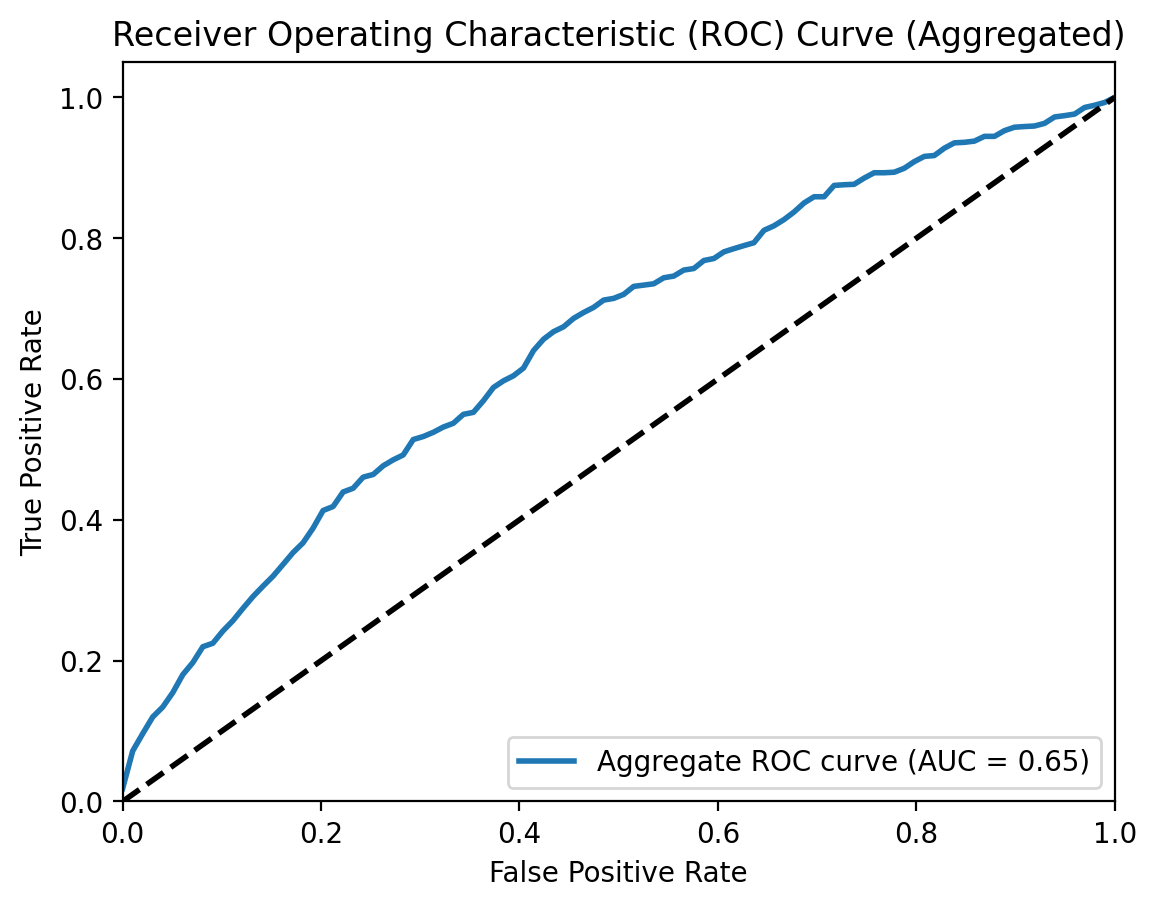

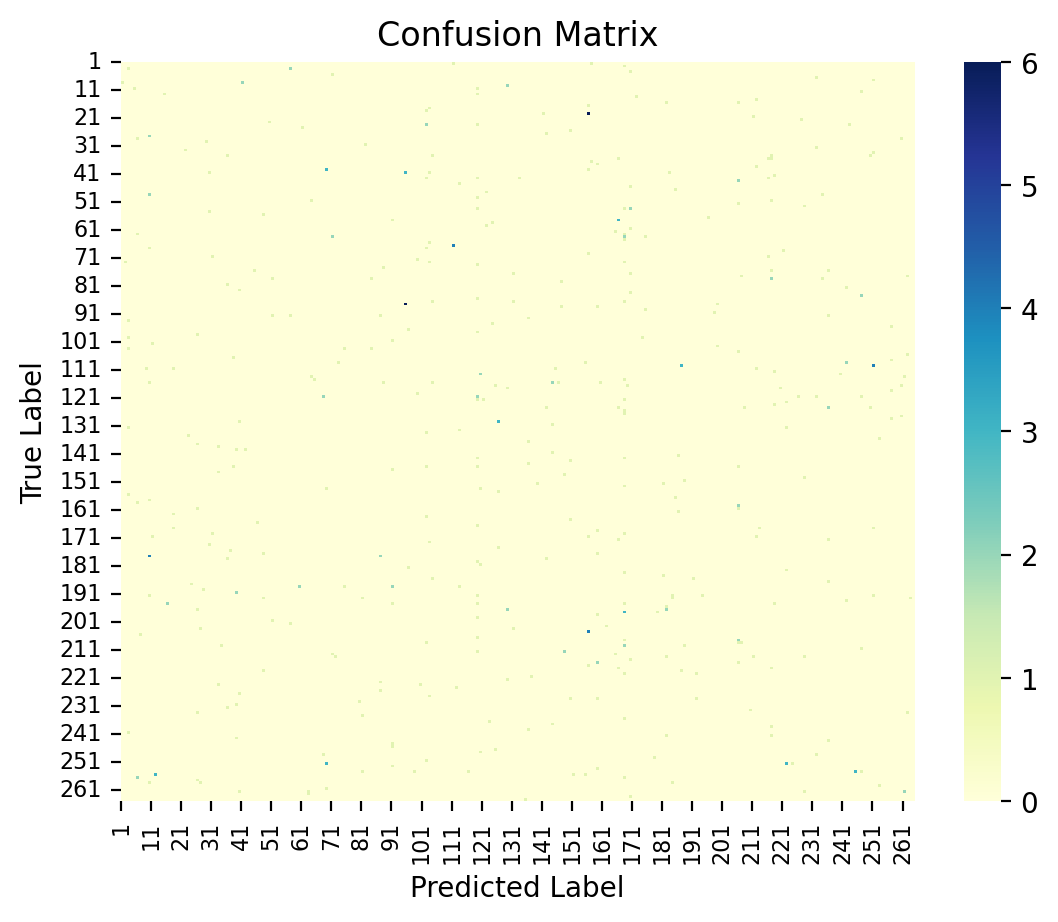

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

cnn.eval()
val_probabilities = []
val_true_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.unsqueeze(1).to(device)
        labels = labels.to(device)

        outputs = cnn(images)
        probabilities = torch.softmax(outputs, dim=1)

        val_probabilities.extend(probabilities.tolist())
        val_true_labels.extend(labels.tolist())

val_probabilities = np.array(val_probabilities)
val_true_labels = np.array(val_true_labels)

val_predictions = np.argmax(val_probabilities, axis=1)
# Compute and print the confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions)
print("Confusion Matrix:")
print(cm)

unique_classes = np.unique(validation_data[:, 1])
target_names = np.unique(validation_data[:,1])

# Compute ROC curves and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for class_id in unique_classes:
    # Create a binary target for the current class
    binary_labels = np.where(val_true_labels == class_id, 1, 0)

    # Calculate the ROC curve and AUC for the current class
    fpr[class_id], tpr[class_id], _ = roc_curve(binary_labels, val_probabilities[:, class_id])
    roc_auc[class_id] = auc(fpr[class_id], tpr[class_id])

# Aggregate TPR and FPR for all classes
all_tpr = np.concatenate([tpr[class_id] for class_id in unique_classes])
mean_fpr = np.linspace(0, 1, 100)

# Compute the mean TPR by interpolating at the mean FPR
mean_tpr = np.zeros_like(mean_fpr)
for class_id in unique_classes:
    mean_tpr += np.interp(mean_fpr, fpr[class_id], tpr[class_id])

mean_tpr /= len(unique_classes)
mean_auc = auc(mean_fpr, mean_tpr)

# Plot the aggregated ROC curve
plt.figure()
plt.plot(mean_fpr, mean_tpr, lw=2, label='Aggregate ROC curve (AUC = %0.2f)' % mean_auc)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Aggregated)')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix
plt.figure()
ax = sns.heatmap(cm, annot=False, fmt="d", cmap="YlGnBu")
ax.set_title('Confusion Matrix')
tick_frequency = 10
x_tick_locs = np.arange(len(unique_classes))
x_tick_labels = unique_classes
plt.xticks(ticks=x_tick_locs[::tick_frequency], labels=x_tick_labels[::tick_frequency], fontsize=8, rotation=90)
y_tick_locs = np.arange(len(unique_classes))
y_tick_labels = unique_classes
plt.yticks(ticks=y_tick_locs[::tick_frequency], labels=y_tick_labels[::tick_frequency], fontsize=8)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()




### Direct Spectrogram

In [ ]:
#Working
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(12288, num_classes)
        self.fc2 = nn.Linear(num_classes, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [15]:

#Load data into batches of 32
batch_size = 32
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

# Initialize the CNN and use +1 for classes due to "no class" being labeled as -1
num_classes = len(meta_data['common_name'].unique())+1
cnn = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# Training loop and attempt to use cuda
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)

for epoch in range(num_epochs):
    print("epoch : ", epoch)
    cnn.train()
    train_loss = 0.0
    train_correct = 0
    i = 0 
    for images, labels in train_loader:
        #load data onto device, either gpu or cpu
        images = images.unsqueeze(1).to(device) 
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        i+=1
        
    # Validation loop
    cnn.eval()
    val_loss = 0.0
    val_correct = 0
    
    with torch.no_grad(): #Disables some calculations, used to reduce memory.
        for images, labels in val_loader:
        #load data onto device, either gpu or cpu
            images = images.unsqueeze(1).to(device)
            labels = labels.to(device)
            
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

NameError: name 'training_set' is not defined

In [ ]:
num_classes

## Plots